In [3]:
#Identifying Drivers of Outcomes: Linear Models
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.stats import anova as sms_anova

#Loading in the amusement park data set
# sat_df = pd.read_csv('http://bit.ly/PMR-ch7')
# sat_df.sample(5)

#Simulating amusement park data

np.random.seed(8266)
n_resp = 500

halo = np.random.normal(loc = 0, scale = 5, size = n_resp)

def genereate_satisfatcion_scores(mean, std, halo,
                                  score_range = (0,100)):
    """Simulate satisfaction scores of a survey questions from a normal distribution"""
    #Draws scores from norm. dist
    scores = np.random.normal(loc = mean, scale = std, size = len(halo))
    #Adds the halo
    scores = scores + halo
    #Floor the scores so they are all integers and clip to limit range
    scores = np.floor(scores)
    scores = np.clip(scores, score_range[0],score_range[1])
    
    return scores

rides = genereate_satisfatcion_scores(mean = 81, std = 3 , halo = halo)
games = genereate_satisfatcion_scores(mean = 75, std = 2, halo = halo)
wait = genereate_satisfatcion_scores(mean = 74, std = 10, halo = halo)
clean = genereate_satisfatcion_scores(mean = 86, std = 2, halo = halo)

np.random.seed(82667)
distance = np.random.lognormal(mean = 3, sigma = 1,  size = n_resp)
num_child = np.random.choice(a = range(6),
                             size = n_resp,
                             replace = True,
                             p = [0.3,0.15,0.25,0.15,0.1,0.05])
weekend = np.random.choice(a = [True, False],
                           size = n_resp,
                           p = [0.5,0.5])

overall = np.floor(0.7 * (halo + 0.5 * rides + 0.15 * games + 0.3 * wait
                          + 0.2 * clean + 0.07 * distance + 5 * (num_child == 0)
                          + 0.3 * wait * (num_child > 0)
                          + np.random.normal(loc = 0, scale = 7, size = n_resp)))
overall = np.clip(overall,0,100)

sat_df = pd.DataFrame({'is_weekend': weekend,
                       'num_child':num_child,
                       'distance':distance,
                       'rides': rides,
                       'games': games,
                       'wait': wait,
                       'clean': clean,
                       'overall':overall})

sat_df.head(5)

,is_weekend,num_child,distance,rides,games,wait,clean,overall
0,True,0,9.844503,82.0,74.0,82.0,88.0,70.0
1,False,1,2.720221,85.0,80.0,100.0,90.0,100.0
2,False,3,1.878189,88.0,82.0,80.0,91.0,95.0
3,False,0,14.211682,73.0,61.0,68.0,74.0,56.0
4,False,1,9.362776,78.0,77.0,56.0,82.0,61.0


C:\Users\Kyle\AppData\Local\Temp\ipykernel_37640\3589111992.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  g = sns.PairGrid(sat_df.replace({False: 0, True: 1}))


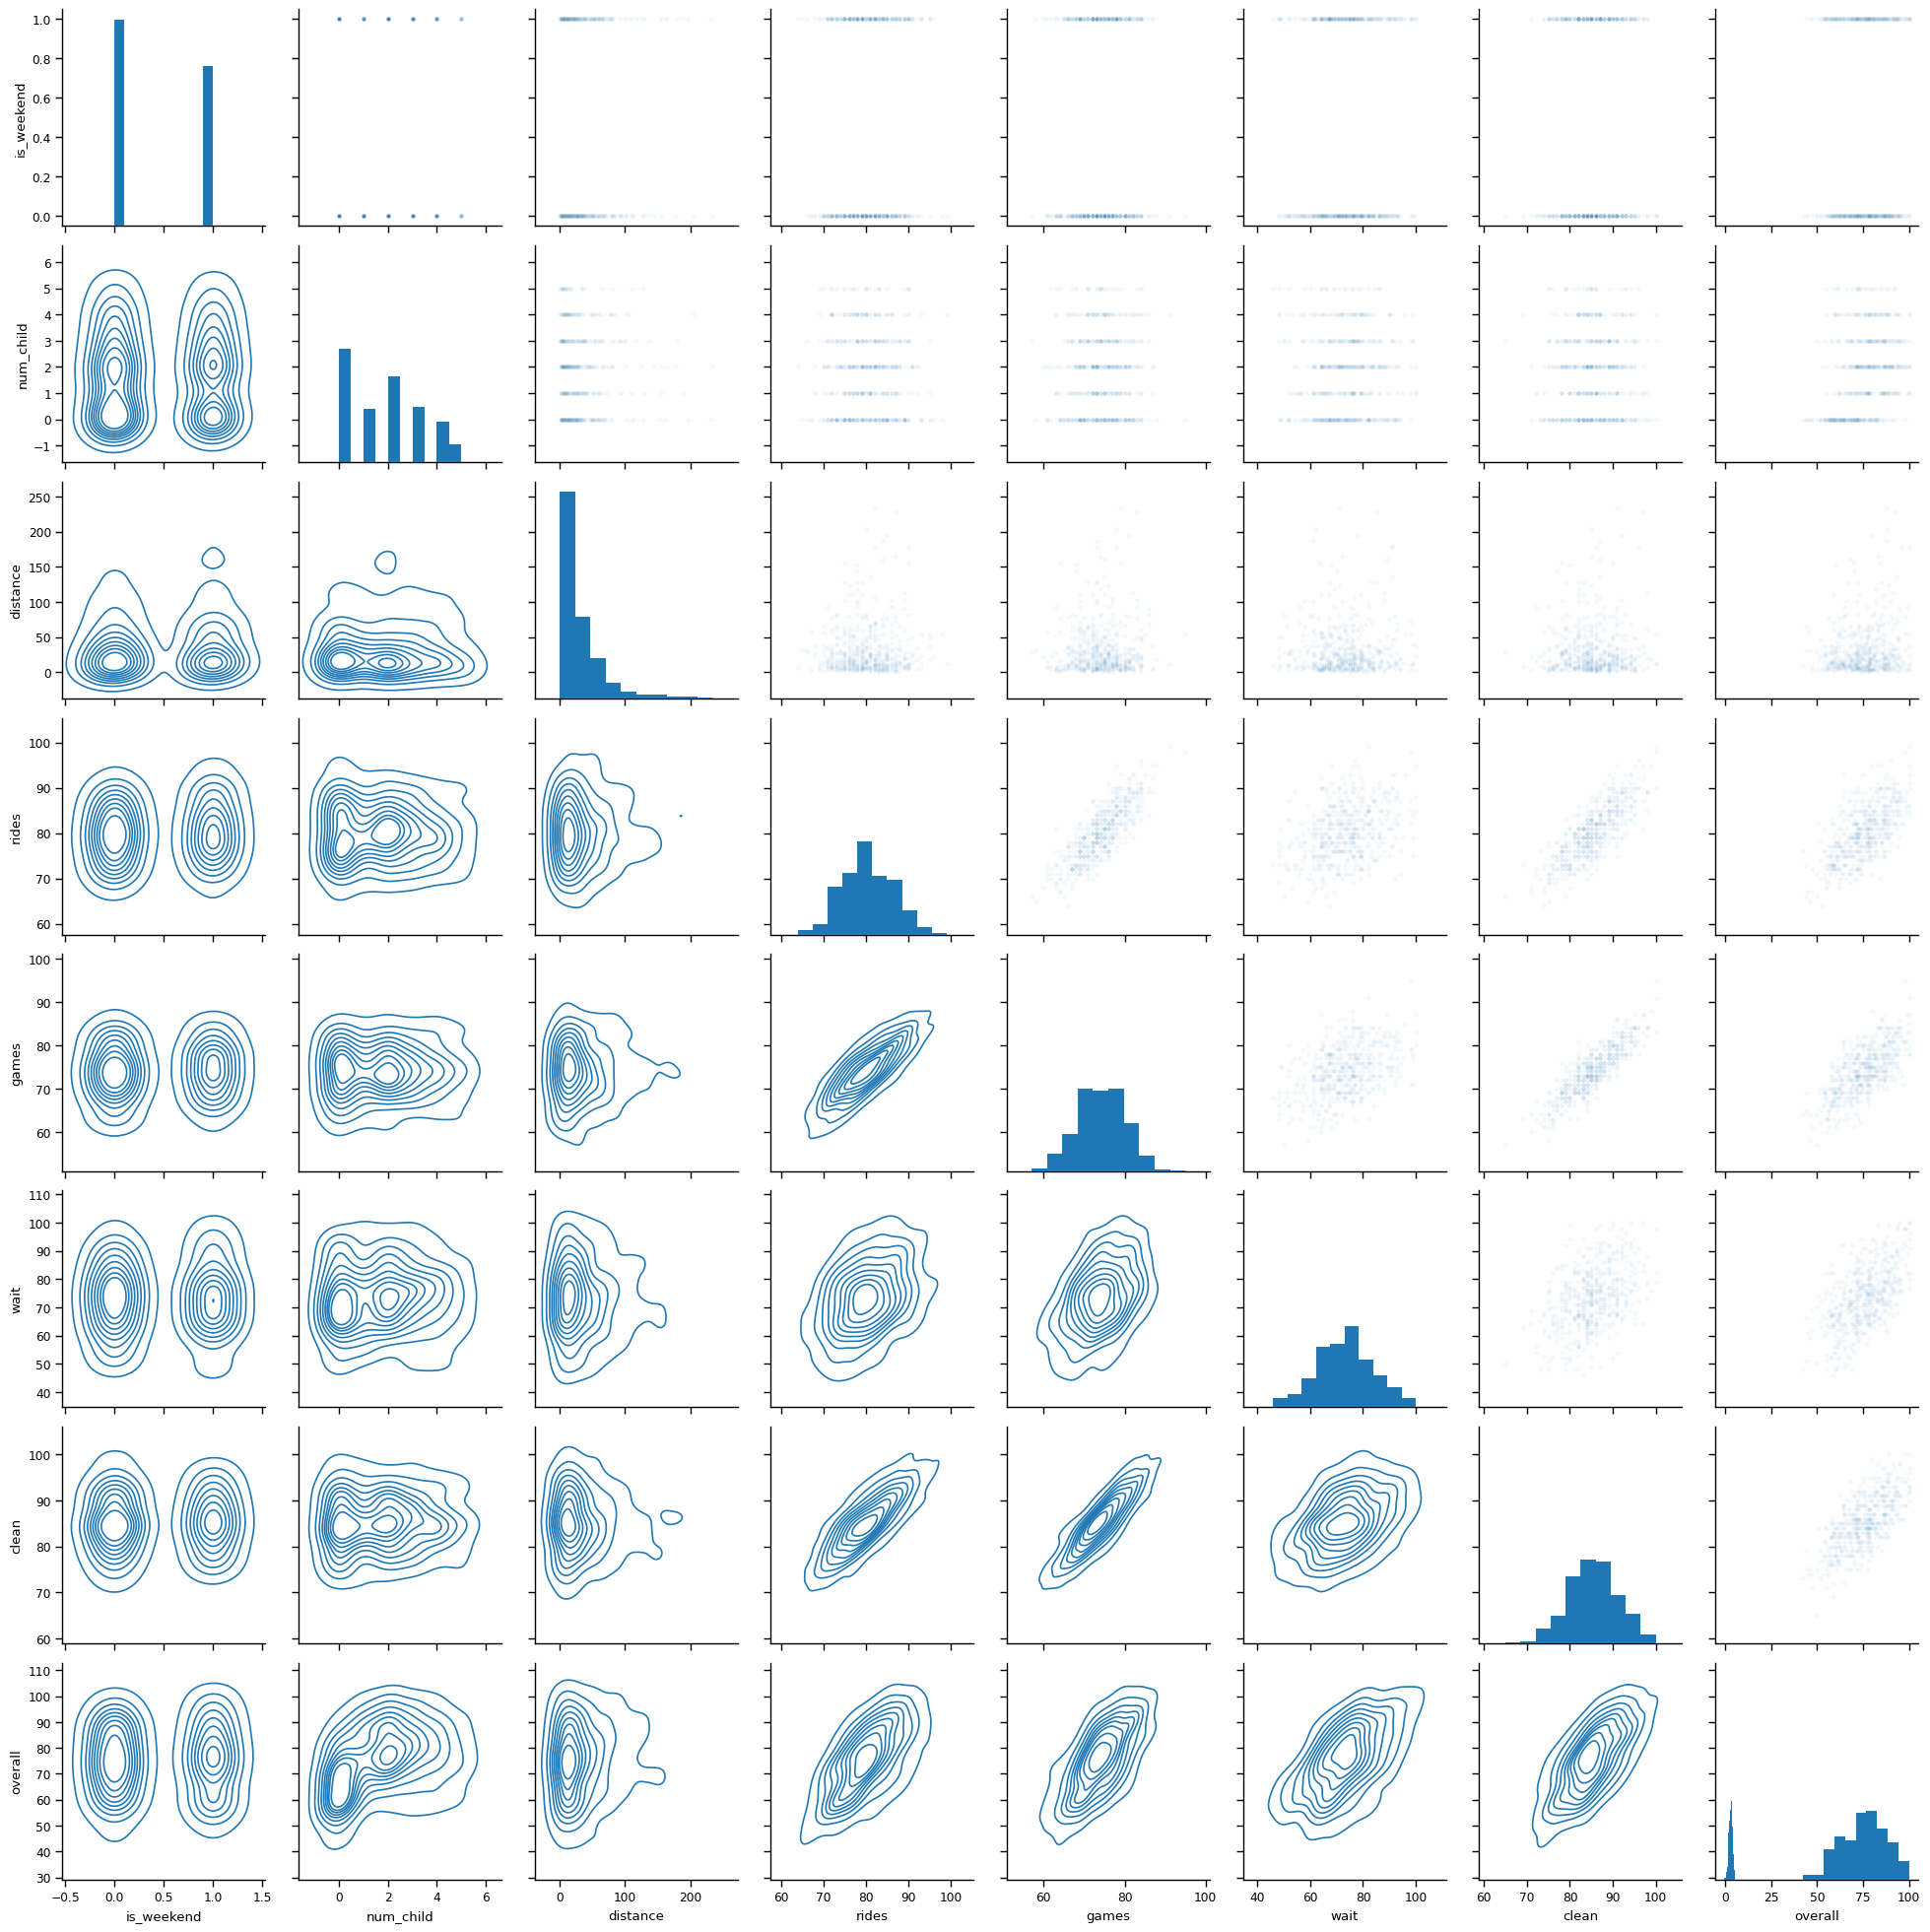

<Axes: >

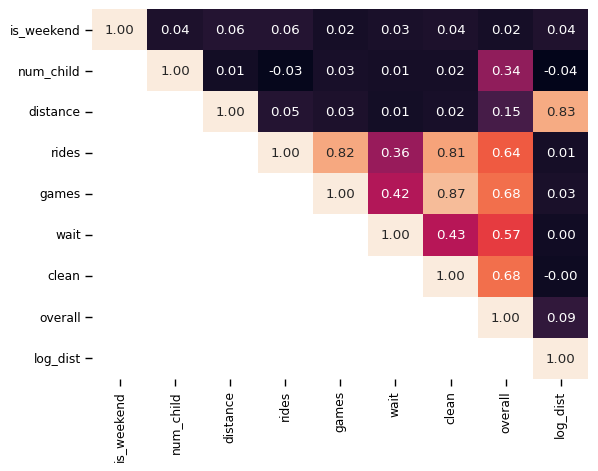

In [4]:
#Preliminary Data Inspection

#Looking at summary stats of dataframe 
sat_df.describe(include = 'all').T.round(2)

#Checking reasonable dist. and joint relationship using seaborn
sns.set_context('paper')

g = sns.PairGrid(sat_df.replace({False: 0, True: 1}))
g.map_upper(sns.scatterplot, linewidth = 1, edgecolor = "w", s = 10,
            alpha = 0.05)
g.map_diag(plt.hist)
g.map_lower(sns.kdeplot)

#adding log of dist. to make more normally dist. 
sat_df['log_dist'] = sat_df.distance.apply(np.log)
sat_df.log_dist.hist()
plt.xlabel('log distance')
plt.ylabel('count')
plt.show()

#Looking at the positive associations
sat_df_corr = sat_df.corr()
sns.heatmap(sat_df_corr, annot = True, fmt = ".2f",
            mask = np.tri(sat_df_corr.shape[1], k = -1, dtype = bool),
            cbar = False)

Text(0, 0.5, 'Satisfaction Overall')

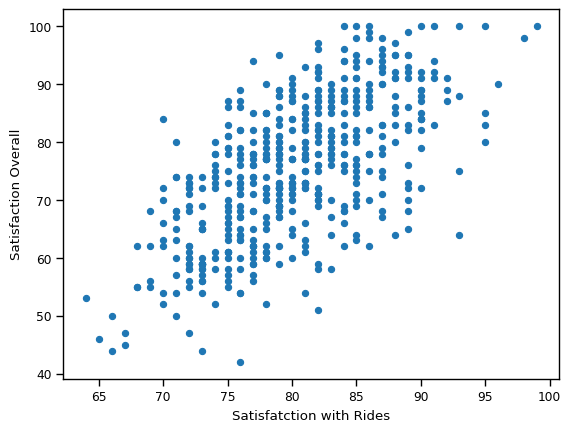

In [5]:
#Recap: Bivariate Association

#Checking Relationship: is it strong or weak using scatterplot
sat_df.plot(kind = "scatter",x = 'rides', y = 'overall')
plt.xlabel("Satisfatction with Rides")
plt.ylabel("Satisfaction Overall")

In [6]:
#linear Model with a Single Predictor

smf.ols('overall ~ rides', data = sat_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                overall   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                     345.3
Date:                Wed, 20 Aug 2025   Prob (F-statistic):           6.14e-59
Time:                        13:47:42   Log-Likelihood:                -1824.4
No. Observations:                 500   AIC:                             3653.
Df Residuals:                     498   BIC:                             3661.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -27.9075      5.572     -5.008      0.000     -38.855     -16.960
rides          1.2878      0.069     18.582      0.000       1.152       1.424
==============================================================================
Omnibus:                        4.927   Durbin-Watson:                   1.878
Prob(Omnibus):                  0.085   Jarque-Bera (JB):                4.605
Skew:                          -0.183   Prob(JB):                        0.100
Kurtosis:                       2.704   Cond. No.                     1.08e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.08e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

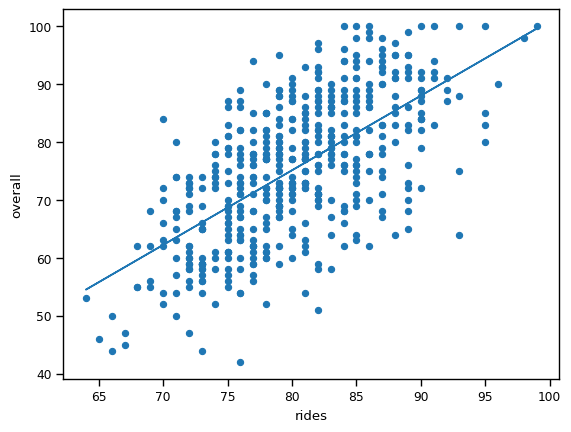

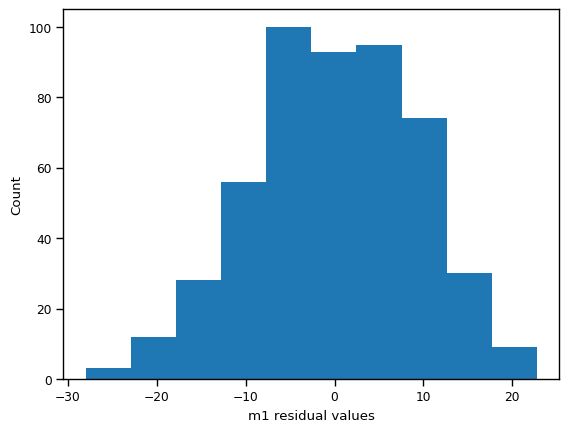

np.float64(9.299261339917885)

In [7]:
#OLS Objects

#creating model one
m1 = smf.ols('overall ~ rides', data = sat_df).fit()

#Looking at params 
m1.params

#Est. overall based on model 
m1.predict({'rides':[95]})

#redraw scatter with predict on it
sat_df.plot(kind = 'scatter', x = 'rides', y = 'overall')
plt.plot(sat_df.rides, m1.predict(sat_df.rides))
plt.show()

#Looking at m1 summary
m1.summary()

#Looking at m1 params
m1.params

#Looking at m1 confidence level 
m1.conf_int()

#r^2 is equal to square of correlation between predictor and outcome
# with a single predictor
np.corrcoef(sat_df.rides, sat_df.overall) ** 2

#Observe the residuals 
m1.resid.max(), m1.resid.min()

#Check symetry of residuals in histogram
plt.hist(m1.resid)
plt.xlabel('m1 residual values')
plt.ylabel('Count')
plt.show()


#Check the stadard deviation of the residuals
np.std(m1.resid)

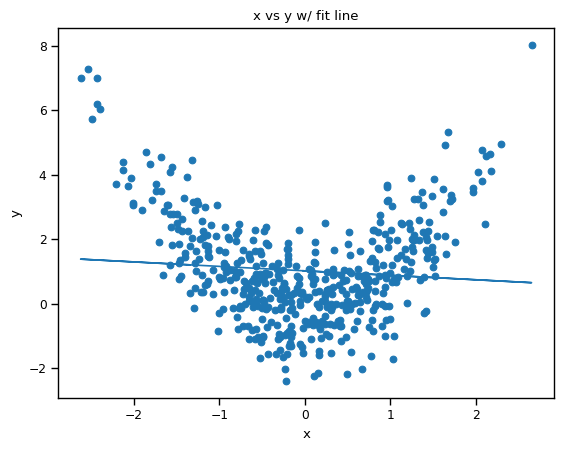

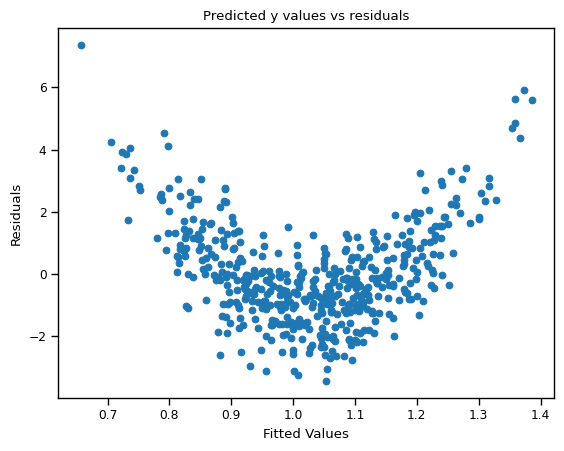

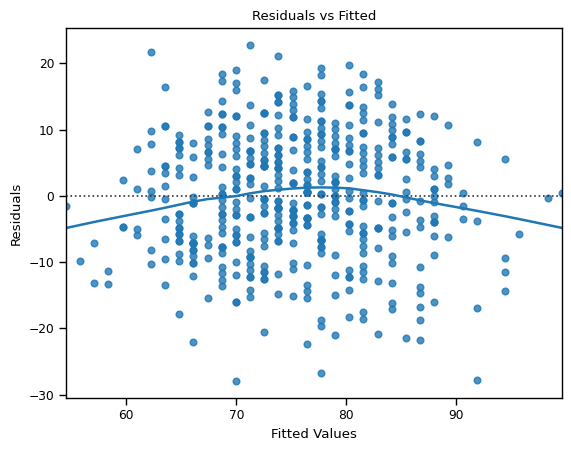

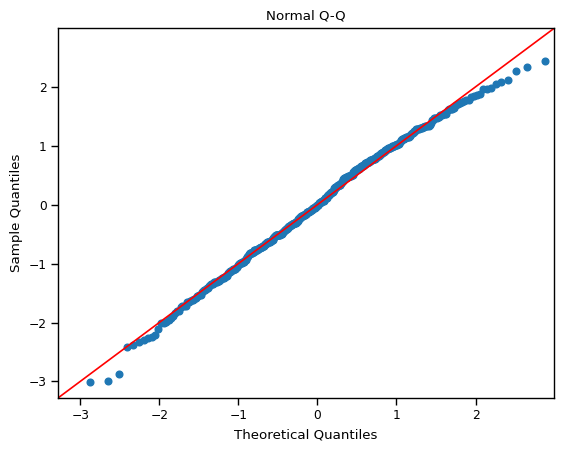

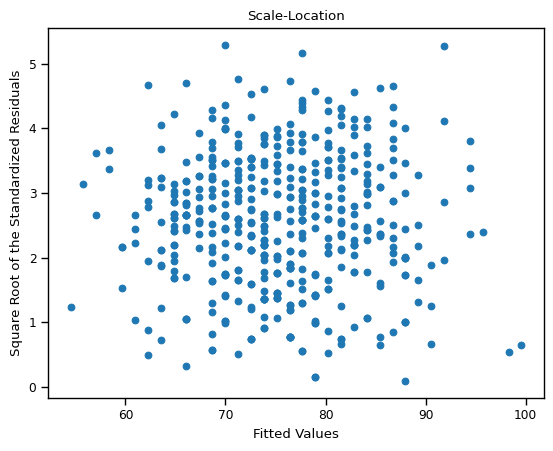

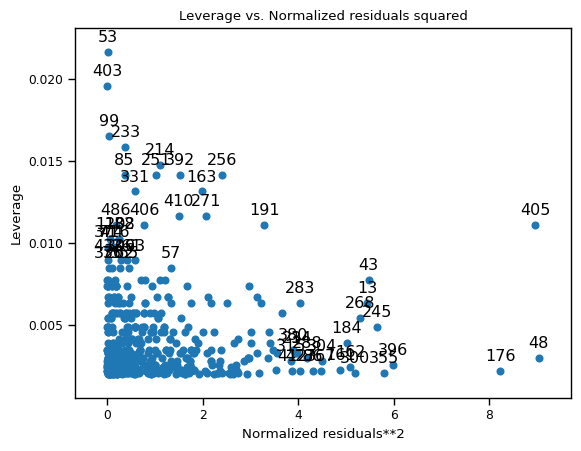

,is_weekend,num_child,distance,rides,games,wait,clean,overall,log_dist
405,True,0,11.445116,93.0,79.0,75.0,89.0,64.0,2.437563
48,False,0,8.434066,76.0,64.0,48.0,73.0,42.0,2.132279
176,True,0,18.318936,82.0,69.0,74.0,84.0,51.0,2.907935


In [8]:
#Checking Model Fit

#Generating data where y is a function of x^2
x = np.random.normal(size = 500)
y = x ** 2 + np.random.normal(size = 500)
toy_model = smf.ols('y ~ x', data = {'x' : x,'y' : y}).fit()
toy_model.summary()

# plotting the model with a fitted line
plt.scatter(x,y)
plt.plot(x, toy_model.predict({'x' : x}))
plt.xlabel('x')
plt.ylabel('y')
plt.title('x vs y w/ fit line')
plt.show()

#plotting when fitted values (predictions) to residuals (prediction errors)
plt.scatter(x = toy_model.fittedvalues, y = toy_model.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Predicted y values vs residuals')
plt.show()

#Similar goodness of fit plots for our satisfaction drivers

from statsmodels.graphics import gofplots
from statsmodels.graphics import regressionplots

def plot_gof_figures(model):
    '''Plot a multipanel figure of goodness of fit plots'''


    sns.residplot(x=model.fittedvalues, y=model.resid, lowess=True)
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Fitted')
    plt.show()

    gofplots.qqplot(model.resid, fit=True, line='45')
    plt.title('Normal Q-Q')
    plt.show()

    plt.scatter(model.fittedvalues, np.sqrt(np.abs(model.resid)))
    plt.xlabel('Fitted Values')
    plt.ylabel('Square Root of the Standardized Residuals')
    plt.title('Scale-Location')
    plt.show()

    regressionplots.plot_leverage_resid2(model)
    plt.show()


#Apply to toy model 
#plot_gof_figures(toy_model)

#plot the m1 model 
plot_gof_figures(m1)

#Looking at the outliers from the last graph
sat_df.loc[[405, 48, 176]]


c:\Users\Kyle\AppData\Local\Programs\Python\Python313\Lib\site-packages\python_marketing_research_functions\chapter6.py:65: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  centers = centers[sort_index]


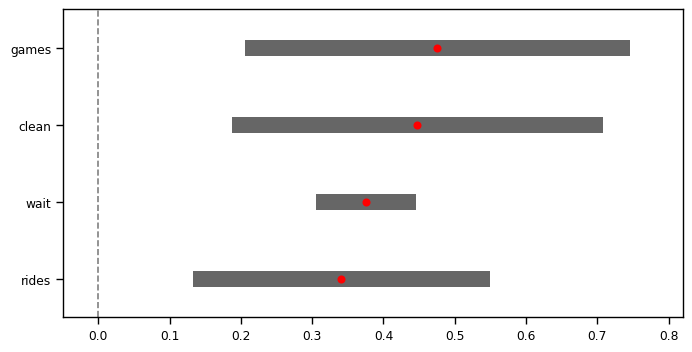

In [9]:
#Fitting Linear Models with Multiple Predictors

#First estimate of model to determine all features are related to overall
m2 = smf.ols('overall ~ rides + games + wait + clean',
             data = sat_df).fit()
m2.summary()

#Looking at std of residuals
np.std(m2.resid)

#Looking at percintile of residuals
np.percentile(m2.resid, q = range(0,101,25))

#Helpful to visualize the coefficients

from python_marketing_research_functions import chapter6

chapter6.plot_confidence_intervals(m2.params[1:],
                                   m2.conf_int().iloc[1:,:],
                                   zero_line = True)

0.4094509479180185
0.5955919792176467
0.4082651064479743
0.5923240356153651


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,498.0,43238.130734,0.0,NaN,NaN,NaN
1,495.0,29609.474117,3.0,13628.656617,75.946244,2.009628e-40


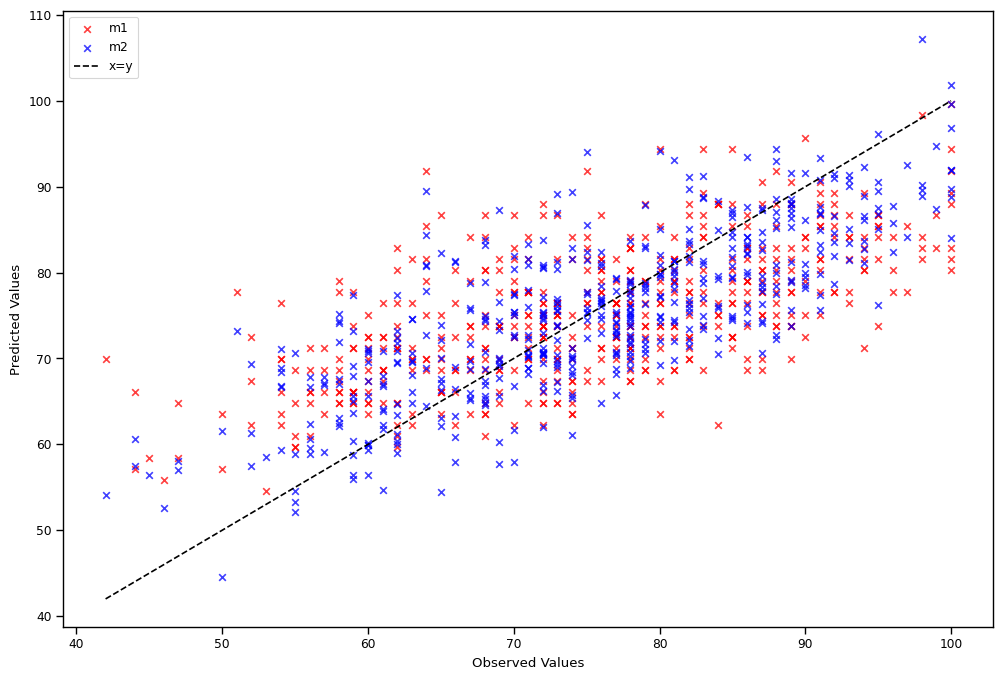

In [10]:
#Comparing Models 

#compare the models using rsquared
print(m1.rsquared)
print(m2.rsquared)

#Look at the adjusted rsquared
print(m1.rsquared_adj)
print(m2.rsquared_adj)

#Comparing predictions visually 
plt.figure(figsize = (12, 8))
plt.scatter(sat_df.overall, m1.fittedvalues, c = 'r' , marker = 'x',
            alpha  = 0.75, label = 'm1')
plt.scatter(sat_df.overall, m2.fittedvalues, c = 'b', marker = 'x',
             alpha = 0.75, label = 'm2')
satisfaction_range = [sat_df.overall.min(), sat_df.overall.max()]
plt.plot(satisfaction_range, satisfaction_range, '--k', label = 'x=y')
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
plt.legend()

#Using anova_lm() to determine  whether m2 explains mor variation than m1

from statsmodels.stats import anova as sms_anova
sms_anova.anova_lm(m1,m2)

In [11]:
# Using a model to make a prediction

#Predict overall rating with coefficients
m2.params.Intercept + m2.params.rides * 100 + m2.params.games * 100 + m2.params.wait * 100 + m2.params.clean * 100

#Find first 10 predictions using predict method
m2.predict(sat_df.head(10))

#Also stored in model using fittedvalues
m2.fittedvalues[:10]

#Using predict method with dict object
m2.predict({'rides': 100,
            'games': 100,
            'wait': 100,
            'clean': 100})

0    111.019874
dtype: float64

In [12]:
#Standardizing the Predictors

#Convert values to zero centered units of standard dev. 
#Getting the Z-score
((sat_df.rides - sat_df.rides.mean())/sat_df.rides.std()).head(10)

#Creating a scaled version of the dataframe
sat_df_scaled = sat_df.copy()
idx = ['clean','games', 'rides', 'wait', 'log_dist','overall']
sat_df_scaled[idx] = (sat_df[idx] - sat_df[idx].mean(axis = 0)) \
/ sat_df[idx].std(axis = 0)

sat_df_scaled.head()

#Checking the describe for mean of 0
sat_df_scaled[idx].describe().round(2)

,clean,games,rides,wait,log_dist,overall
count,500.00,500.00,500.00,500.00,500.00,500.00
mean,0.00,0.00,0.00,0.00,0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00
min,-3.53,-3.03,-2.69,-2.55,-3.16,-2.75
25%,-0.57,-0.73,-0.69,-0.68,-0.68,-0.69
50%,-0.04,-0.02,-0.03,-0.03,0.03,0.05
75%,0.65,0.69,0.64,0.62,0.69,0.80
max,2.57,3.69,3.13,2.49,2.36,2.04


In [18]:
#Using factors as a predictor

#Looking at weekend and travel and children
m3 = smf.ols('overall ~ rides + games + wait + clean + is_weekend + log_dist + num_child',
            data = sat_df_scaled).fit()
m3.summary()

#Convert num children to factor for better analysis
dummy_vals = pd.get_dummies(sat_df_scaled.num_child, prefix = 'num_child')
dummy_vals.head(5)

sat_df_child_factor = sat_df_scaled.join(dummy_vals)

#Create new model with dummy variables
m4 = smf.ols('overall ~ rides + games + wait + clean + log_dist'
             '+ num_child_0 + num_child_1 + num_child_2 + num_child_3'
             '+ num_child_4 + num_child_5',
             data = sat_df_child_factor).fit()

m4.summary()

#Creating a has child factor 
sat_df_scaled['has_child'] = sat_df_scaled.num_child.apply(lambda x: x > 0)

m5 = smf.ols('overall ~ rides + games + wait + clean + log_dist'
             '+ has_child', data = sat_df_scaled).fit()

m5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                overall   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     368.1
Date:                Wed, 20 Aug 2025   Prob (F-statistic):          1.56e-178
Time:                        14:25:18   Log-Likelihood:                -283.67
No. Observations:                 500   AIC:                             581.3
Df Residuals:                     493   BIC:                             610.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.6933      0.035    -20.031      0.000      -0.761      -0.625
has_child[T.True]     1.0048      0.042     24.086      0.000       0.923       1.087
rides                 0.2297      0.036      6.465      0.000       0.160       0.300
games                 0.1742      0.043      4.019      0.000       0.089       0.259
wait                  0.3121      0.021     14.581      0.000       0.270       0.354
clean                 0.2013      0.042      4.760      0.000       0.118       0.284
log_dist              0.0951      0.019      4.931      0.000       0.057       0.133
==============================================================================
Omnibus:                        0.415   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.813   Jarque-Bera (JB):                0.484
Skew:                          -0.066   Prob(JB):                        0.785
Kurtosis:                       2.923   Cond. No.                         4.83
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

c:\Users\Kyle\AppData\Local\Programs\Python\Python313\Lib\site-packages\python_marketing_research_functions\chapter6.py:65: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  centers = centers[sort_index]


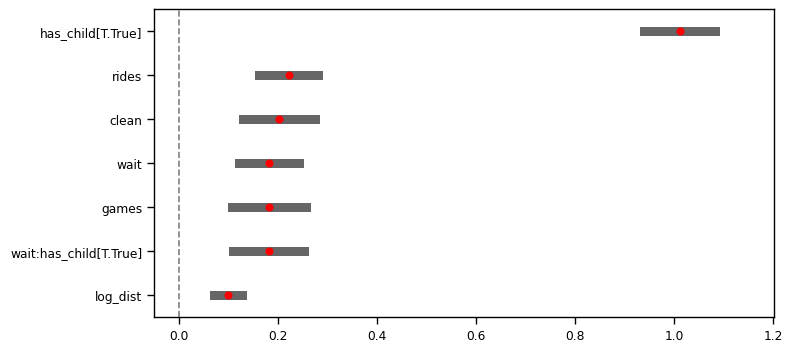

In [23]:
#Interaction Terms

#Create new model to look at interactions of child weekend
m6 = smf.ols('overall ~ rides + games + wait + clean + log_dist'
             '+ has_child + rides:has_child + games:has_child'
             '+ wait:has_child + clean:has_child + rides:is_weekend'
             '+ games:is_weekend + wait:is_weekend + clean:is_weekend',
             data = sat_df_scaled).fit()
m6.summary()

#Drop non-significant factors 
m7 = smf.ols('overall ~ rides + games + wait + clean + log_dist'
             '+ has_child + wait:has_child',
             data = sat_df_scaled).fit()
m7.summary()

#create plot confidence variable
chapter6.plot_confidence_intervals(m7.params[1:], m7.conf_int().iloc[1:],
                                   zero_line = True)

In [ ]:
#Syntax for including interatcions in modesl 

# y ~ x                               y is a linear function of x
# y ~ x - 1                           omit the intercept
# y ~ x + z                           y is linear combo of x and z 
# y ~ x x : z                         include the interaction between x and z
# y ~ x * z                           Include x, z and the interaction between
# y ~ (u + v + w) *** 3               include u,v,w and all interactions among them 3 ways
# y ~ (u + v + w) *** 3 - u : v       Include these variables and all interactions except u, v